In [0]:
alpha = 100 # taking 150 because visually makes more sense for human eye

import numpy as np
import matplotlib.pyplot as plt
import torch
import torchvision
import torchvision.transforms as transforms

In [2]:
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5, ), (0.5, ))])

trainset = torchvision.datasets.MNIST(root = './data', train = True, download = True, transform = transform)

testset = torchvision.datasets.MNIST(root = './data', train = False, download = True, transform = transform)

trainset_forpatch = torchvision.datasets.MNIST(root = './data', train = True, download = True, transform = transform)

testset_forpatch = torchvision.datasets.MNIST(root = './data', train = False, download = True, transform = transform)

  0%|          | 0/9912422 [00:00<?, ?it/s]

9920512it [00:00, 21324641.71it/s]                            


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw


32768it [00:00, 316485.64it/s]                           
0it [00:00, ?it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw


1654784it [00:00, 5311050.86it/s]                           
8192it [00:00, 130661.29it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw
Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw
Processing...
Done!


In [0]:
# Odd (1) v even (0) labels
trainset.targets[np.where(trainset.targets %2 != 0)[0].tolist()] = 1
trainset.targets[np.where(trainset.targets %2 == 0)[0].tolist()] = 0

testset.targets[np.where(testset.targets %2 != 0)[0].tolist()] = 1
testset.targets[np.where(testset.targets %2 == 0)[0].tolist()] = 0

trainset_forpatch.targets[np.where(trainset_forpatch.targets %2 != 0)[0].tolist()] = 1
trainset_forpatch.targets[np.where(trainset_forpatch.targets %2 == 0)[0].tolist()] = 0

testset_forpatch.targets[np.where(testset_forpatch.targets %2 != 0)[0].tolist()] = 1
testset_forpatch.targets[np.where(testset_forpatch.targets %2 == 0)[0].tolist()] = 0

In [0]:
# Converting the data type to float in order to be able to add Gaussian noise
trainset.data = trainset.data.type(torch.float64)
testset.data = testset.data.type(torch.float64)
trainset_forpatch.data = trainset_forpatch.data.type(torch.float64)
testset_forpatch.data = testset_forpatch.data.type(torch.float64)

In [0]:
# Generating MNIST_bin(alpha)
def GaussianNoise_alpha(trainset1, testset1, alpha):
  for im in range(len(trainset1)):
#     trainset1.data[im] = torch.tensor(trainset1.data[im], dtype = torch.float64) + torch.tensor(np.random.normal(scale = alpha, size = (28, 28)), dtype = torch.float64)
    trainset1.data[im] = trainset1.data[im] + torch.tensor(np.random.normal(scale = alpha, size = (28, 28)), dtype = torch.float64)
    trainset1.data[im] = np.clip(trainset1.data[im], 0, 255)
  for jm in range(len(testset1)):
#     testset1.data[jm] = torch.tensor(testset1.data[jm], dtype = torch.float64) + torch.tensor(np.random.normal(scale = alpha, size = (28, 28)), dtype = torch.float64)
    testset1.data[jm] = testset1.data[jm] + torch.tensor(np.random.normal(scale = alpha, size = (28, 28)), dtype = torch.float64)
    testset1.data[jm] = np.clip(testset1.data[jm], 0, 255)
  return trainset1, testset1


# Generating MNIST_bin_patch(alpha)
def GaussianNoise_alpha_patch(trainset1, testset1): # Feed in the data with gaussian noise already added
# Left patch for   
  for im in range(len(trainset1)):
    if trainset1.targets[im] == 0:
      for p1 in range(3):
        for p2 in range(3):
          trainset1.data[im][p1, p2] = 255
    else:
      for p1 in range(3):
        for p2 in range(25, 28):
          trainset1.data[im][p1, p2] = 255

  for im in range(len(testset1)):
    if testset1.targets[im] == 0:
      for p1 in range(3):
        for p2 in range(3):
          testset1.data[im][p1, p2] = 255
    else:
      for p1 in range(3):
        for p2 in range(25, 28):
          testset1.data[im][p1, p2] = 255
          
  return trainset1, testset1 

# Increase the illumination level for label = 0
def ChangeIllumination(trainset1, testset1):
  for im in range(len(trainset1)):
    if trainset1.targets[im] == 0:
      xx = np.clip(trainset1.data[im] + 100 * torch.ones((28, 28)), 0, 254)
      trainset1.data[im] = xx
  for im in range(len(testset1)):
    if testset1.targets[im] == 0:
      xx = np.clip(testset1.data[im] + 100 * torch.ones((28, 28)), 0, 254)
      testset1.data[im]  = xx
  return trainset1, testset1

In [0]:
# Creating the bin data
train_bin, test_bin = GaussianNoise_alpha(trainset, testset, alpha)

# # Creating the bin data with patches
train_inter, test_inter = GaussianNoise_alpha(trainset_forpatch, testset_forpatch, alpha)
train_bin_patch, test_bin_patch = GaussianNoise_alpha_patch(train_inter, test_inter)

In [0]:
# Converting the data type back to unit8...

train_bin.data = train_bin.data.type(torch.uint8)
test_bin.data = test_bin.data.type(torch.uint8)
train_bin_patch.data = train_bin_patch.data.type(torch.uint8)
test_bin_patch.data = test_bin_patch.data.type(torch.uint8)

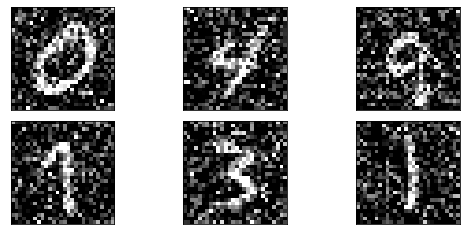

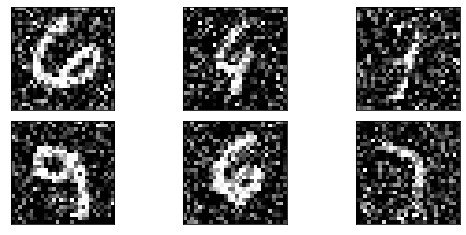

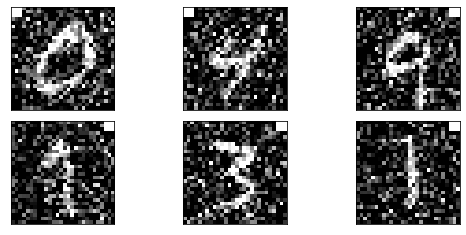

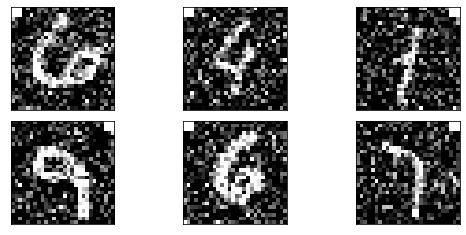

In [0]:
# Plot random train and test images
# Training images
fig, axes = plt.subplots(2, 3, figsize=(9, 4),
                         subplot_kw={'xticks':[], 'yticks':[]},
                         gridspec_kw=dict(hspace=0.1, wspace=0.1))
for i, ax in zip([1, 115, 460, 212, 130, 10020], axes.flat):
    ax.imshow(train_bin.data[i], cmap='gray', vmin=0, vmax=255)
    
#Test images without patch 
fig, axes = plt.subplots(2, 3, figsize=(9, 4),
                         subplot_kw={'xticks':[], 'yticks':[]},
                         gridspec_kw=dict(hspace=0.1, wspace=0.1))
for i, ax in zip([201, 115, 1500, 212, 130, 122], axes.flat):
    ax.imshow(test_bin.data[i], cmap='gray', vmin=0, vmax=255)  
    
# Training images
fig, axes = plt.subplots(2, 3, figsize=(9, 4),
                         subplot_kw={'xticks':[], 'yticks':[]},
                         gridspec_kw=dict(hspace=0.1, wspace=0.1))
for i, ax in zip([1, 115, 460, 212, 130, 10020], axes.flat):
    ax.imshow(train_bin_patch.data[i], cmap='gray', vmin=0, vmax=255)
    
# Test images without patch 
fig, axes = plt.subplots(2, 3, figsize=(9, 4),
                         subplot_kw={'xticks':[], 'yticks':[]},
                         gridspec_kw=dict(hspace=0.1, wspace=0.1))
for i, ax in zip([201, 115, 1500, 212, 130, 122], axes.flat):
    ax.imshow(test_bin_patch.data[i], cmap='gray', vmin=0, vmax=255)      

In [0]:
# Assign data to data loader

trainloader = torch.utils.data.DataLoader(train_bin, batch_size = 64, shuffle = True, num_workers = 2)

testloader = torch.utils.data.DataLoader(test_bin, batch_size = 64, shuffle = False, num_workers = 2)

trainloader_patch = torch.utils.data.DataLoader(train_bin_patch, batch_size = 64, shuffle = True, num_workers = 2)

testloader_patch = torch.utils.data.DataLoader(test_bin_patch, batch_size = 64, shuffle = False, num_workers = 2)

In [0]:
# Developing the model

# 1 convolutional layered CNN to start with
import torch.nn as nn
import torch.nn.functional as F

class linear_model(nn.Module):
  def __init__(self):
    super(linear_model, self).__init__()
    self.conv1 = nn.Conv2d(1, 1, 5)
    torch.nn.init.xavier_uniform_(self.conv1.weight)
    self.conv2 = nn.Conv2d(1, 1, 5)
    torch.nn.init.xavier_uniform_(self.conv2.weight)
    self.conv3 = nn.Conv2d(1, 1, 5)
    torch.nn.init.xavier_uniform_(self.conv3.weight)
    self.conv4 = nn.Conv2d(1, 1, 5)
    torch.nn.init.xavier_uniform_(self.conv4.weight)
    self.conv5 = nn.Conv2d(1, 1, 5)
    torch.nn.init.xavier_uniform_(self.conv5.weight)
    self.conv6 = nn.Conv2d(1, 1, 5)
    torch.nn.init.xavier_uniform_(self.conv6.weight)
    self.fc11 = nn.Linear(24 * 24, 20)
    torch.nn.init.xavier_uniform_(self.fc11.weight)
    self.fc21 = nn.Linear(24 * 24, 20)
    torch.nn.init.xavier_uniform_(self.fc21.weight)
    self.fc31 = nn.Linear(24 * 24, 20)
    torch.nn.init.xavier_uniform_(self.fc31.weight)
    self.fc41 = nn.Linear(24 * 24, 20)
    torch.nn.init.xavier_uniform_(self.fc41.weight)
    self.fc51 = nn.Linear(24 * 24, 20)
    torch.nn.init.xavier_uniform_(self.fc51.weight)
    self.fc61 = nn.Linear(24 * 24, 20)
    torch.nn.init.xavier_uniform_(self.fc61.weight)
    self.fc12 = nn.Linear(20, 2)
    torch.nn.init.xavier_uniform_(self.fc12.weight)
    self.fc22 = nn.Linear(20, 2)
    torch.nn.init.xavier_uniform_(self.fc22.weight)
    self.fc32 = nn.Linear(20, 2)
    torch.nn.init.xavier_uniform_(self.fc32.weight)
    self.fc42 = nn.Linear(20, 2)
    torch.nn.init.xavier_uniform_(self.fc42.weight)
    self.fc52 = nn.Linear(20, 2)
    torch.nn.init.xavier_uniform_(self.fc52.weight)
    self.fc62 = nn.Linear(20, 2)
    torch.nn.init.xavier_uniform_(self.fc62.weight)

  def forward(self, x):
    # x = x.view(-1, 28*28)
    x1 = F.relu(self.conv1(x))
    x2 = F.relu(self.conv2(x)) 
    x3 = F.relu(self.conv3(x)) 
    x4 = F.relu(self.conv4(x)) 
    x5 = F.relu(self.conv5(x)) 
    x6 = F.relu(self.conv6(x)) 
    x1 = x1.view(-1, 24 * 24)
    x2 = x2.view(-1, 24 * 24)
    x3 = x3.view(-1, 24 * 24)
    x4 = x4.view(-1, 24 * 24)
    x5 = x5.view(-1, 24 * 24)
    x6 = x6.view(-1, 24 * 24)
    x1 = F.relu(self.fc11(x1))
    x2 = F.relu(self.fc21(x2)) 
    x3 = F.relu(self.fc31(x3)) 
    x4 = F.relu(self.fc41(x4)) 
    x5 = F.relu(self.fc51(x5)) 
    x6 = F.relu(self.fc61(x6)) 
    x1 = self.fc12(x1)
    x2 = self.fc22(x2)
    x3 = self.fc32(x3)
    x4 = self.fc42(x4)
    x5 = self.fc52(x5)
    x6 = self.fc62(x6)
    
    return x1, x2, x3, x4, x5, x6 
    
model = linear_model()  

In [0]:
# Defining the loss function

import torch.optim as optim

criterion = nn.CrossEntropyLoss()

optimizer = optim.Adam(model.parameters(), lr = 0.001)
# optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

In [0]:
#Script for generating fancy inner product matrix:

sigma = 100 #HIGHER VALUES OF SIGMA SEEM TO PERFORM BETTER
M = torch.zeros([5*5, 5*5])

M_tensor = M.view(5,5,5,5)

for i_1 in range(5):
    for i_2 in range(5):
        for j_1 in range(5):
            for j_2 in range(5):
                M_tensor[i_1,i_2,j_1,j_2] = np.exp( -((i_1 - j_1)**2 + (i_2 - j_2)**2) / (2 * (sigma)**2) )

M = M_tensor.view([5*5,5*5])

In [0]:
class custom_loss(torch.nn.Module):

  def __init__(self):
    super(custom_loss,self).__init__()

  def forward(self, model1, model2, M):
    
    # return sum of squared difference
    # l = torch.sum((models[0] - models[1]) * (models[0] - models[1]))

    # return square of cosine of angle between flattened filter weights
    # l = ((torch.mm(model1.view(1, 25), model2.view(1, 25).t())) / (torch.sqrt(torch.mm(model1.view(1, 25), model1.view(1, 25).t())) * torch.sqrt(torch.mm(model2.view(1, 25), model2.view(1, 25).t()))))**2

    # return square of spatially aware dot product of flattened filter weights
    l = (torch.mm(model1.view(1, 25), torch.mm(M, model2.view(1, 25).t())))**2
  
    # return sum of absolute difference
    # l = torch.sum(torch.abs(model.conv1.weight - model.conv2.weight))

    return l

sl = custom_loss()

class custom_loss_conicity(torch.nn.Module):

  def __init__(self):
    super(custom_loss_conicity,self).__init__()

  def forward(self, models): 
    
    mean_weight = torch.zeros((1, 25))
    
    for i in models:
      mean_weight += i.view((1, 25))
    
    mean_weight = mean_weight / len(models) 
    
    coni = 0
    
    for i1 in models:
      coni += (torch.mm(i1.view((1, 25)), mean_weight.t())) / (torch.sqrt(torch.mm(i1.view((1, 25)), i1.view((1, 25)).t())) * torch.sqrt(torch.mm(mean_weight, mean_weight.t())))   
    coni = coni / len(models)

    return coni * coni

sl_coni = custom_loss_conicity()

In [0]:
# A list of all weight vectors

models_forloss = [model.conv1.weight, model.conv2.weight, model.conv3.weight, model.conv4.weight, model.conv5.weight, model.conv6.weight]

In [0]:
n_epochs = 15

lmbda = 10
# l_reg = 0

for epochs in range(n_epochs):
 
  running_loss = 0
  
  for batch in trainloader_patch:
    data, targets = batch
    
    optimizer.zero_grad()
    
    output = model(data)

    loss = criterion(output[0], targets) #+ criterion(output[1], targets) + lmbda * sl.forward(models_forloss[0], models_forloss[1])  
    # print('L1', loss_function(output[0], targets.view(-1, 1).float()))
    # print('L2', loss_function(output[1], targets.view(-1, 1).float()))
    # print('R1', reg.forward(model.fc1.weight))
    # print('R2', reg.forward(model.fc2.weight))
    # print('O1', cus.forward(model.fc1.weight, model.fc2.weight, M))
    # loss = loss_function(output[0], targets.view(-1, 1).float())
    
    for mm in range(1, len(models_forloss)):
      
      loss += criterion(output[mm], targets)

    loss += lmbda * sl_coni(models_forloss)[0][0]
    # for fr in range((len(models_forloss) - 1)):
      
    #   for sn in range(fr + 1, len(models_forloss)):  
        
    #     loss += lmbda * sl.forward(models_forloss[fr], models_forloss[sn], M)[0][0]

    # for mm1 in range(len(models_forloss)):
      
    #   loss += l_reg * reg.forward(models_forloss[mm1])

    loss.backward()
    
    optimizer.step()
    
    running_loss += loss.item()
  
  print(running_loss)    

385.70577650074847
2.736799596605124
0.80011320138874
0.31190546021935006
0.1498140750636594
0.07910161084328138
0.04308463593019951
0.02514565908984423
0.01437073805197997
0.00807540881507407
0.0047890156542393925


In [0]:
# Test performance on the entire test set
correct = 0
total = 0
with torch.no_grad():
  for data in testloader:
    images, labels = data
    outputs = model(images)[0]
    _, predicted = torch.max(outputs.data, 1)
    total += labels.size(0)
    correct += (predicted == labels).sum().item()
  print('Accuracy of the network on the entire data set is : %d %%' %(100 * correct/ total))

In [0]:
sl_coni(models_forloss)

tensor([[5.3691e-12]], grad_fn=<MulBackward0>)